In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from dask_ml.preprocessing import Categorizer
from glum import GeneralizedLinearRegressor, TweedieDistribution
from lightgbm import LGBMRegressor
from sklearn.compose import ColumnTransformer
from sklearn.metrics import auc
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, SplineTransformer, StandardScaler

from ps3.data import create_sample_split, load_transform

In [3]:
# load data
df = load_transform()

In [4]:
weight = df["Exposure"].values
df["PurePremium"] = df["ClaimAmountCut"] / df["Exposure"]
y = df["PurePremium"]

In [5]:
df = create_sample_split(df, "IDpol")
train = np.where(df["sample"] == "train")
test = np.where(df["sample"] == "test")
df_train = df.iloc[train].copy()
df_test = df.iloc[test].copy()

categoricals = ["VehBrand", "VehGas", "Region", "Area", "DrivAge", "VehAge", "VehPower"]

predictors = categoricals + ["BonusMalus", "Density"]
glm_categorizer = Categorizer(columns=categoricals)

X_train_t = glm_categorizer.fit_transform(df[predictors].iloc[train])
X_test_t = glm_categorizer.transform(df[predictors].iloc[test])
y_train_t, y_test_t = y.iloc[train], y.iloc[test]
w_train_t, w_test_t = weight[train], weight[test]

TweedieDist = TweedieDistribution(1.5)
t_glm1 = GeneralizedLinearRegressor(family=TweedieDist, l1_ratio=1, fit_intercept=True)
t_glm1.fit(X_train_t, y_train_t, sample_weight=w_train_t)

pd.DataFrame(
    {"coefficient": np.concatenate(([t_glm1.intercept_], t_glm1.coef_))},
    index=["intercept"] + t_glm1.feature_names_,
).T

df_test["pp_t_glm1"] = t_glm1.predict(X_test_t)
df_train["pp_t_glm1"] = t_glm1.predict(X_train_t)

print(
    "training loss t_glm1:  {}".format(
        TweedieDist.deviance(y_train_t, df_train["pp_t_glm1"], sample_weight=w_train_t)
        / np.sum(w_train_t)
    )
)

print(
    "testing loss t_glm1:  {}".format(
        TweedieDist.deviance(y_test_t, df_test["pp_t_glm1"], sample_weight=w_test_t)
        / np.sum(w_test_t)
    )
)

print(
    "Total claim amount on test set, observed = {}, predicted = {}".format(
        df["ClaimAmountCut"].values[test].sum(),
        np.sum(df["Exposure"].values[test] * t_glm1.predict(X_test_t)),
    )
)

training loss t_glm1:  73.32811172754337
testing loss t_glm1:  75.50833524988694
Total claim amount on test set, observed = 10131723.57, predicted = 9904325.414234586


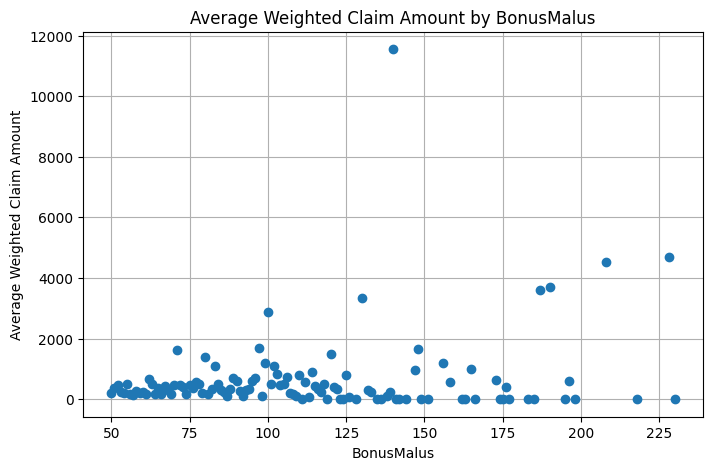

In [11]:
df["WeightedClaims"] = df["ClaimAmount"]/df["Exposure"]
grouped = df.groupby(["BonusMalus"])["WeightedClaims"].mean()

bonus_values = grouped.index.values
avg_claims = grouped.values

plt.figure(figsize=(8,5))
plt.plot(bonus_values, avg_claims, 'o')
plt.xlabel("BonusMalus")
plt.ylabel("Average Weighted Claim Amount")
plt.title("Average Weighted Claim Amount by BonusMalus")
plt.grid(True)
plt.savefig("avg_claims_plot.png")
plt.show()


## Question 1 answer
If we do not include a monotononicity constraint, the claims that are outliers could skew the model training, so that it predicts a non-monotonic function.
Specifically, we want the model to predict higher premiums for riskier drivers, so the BonusMalus feature should be increasing.
Without constraining the model to this, it could output a different use a non-increasing or non-monotonic function, which isn't in line with what we want and will not be useful when tested in production with unseen data.